In [1]:
# for plotting
import matplotlib.pyplot as plt

# numpy is the standard numerical library for Python
import numpy as np

# torch is the deep learning library we are using in this course
import torch
# the basic building block for graphs
from torch import nn
from torch.nn import functional as F
# needed for training the network
from torch import optim

# zeiterfassung
from time import time

**Given is a collection of 20000 labelled images from the MNIST dataset (images: data_x, labels: data_y).**


torch.Size([20000, 784]) torch.float32
torch.Size([20000]) torch.int64


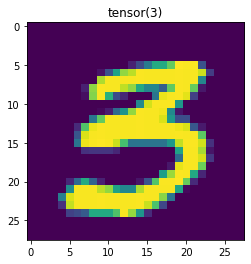

GPU support


In [2]:
with np.load('vae-cvae-challenge.npz') as fh:
    data = torch.from_numpy(fh['data_x'])
    label = torch.from_numpy(fh['data_y'])

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER (6000)
# 2/3. INDEX: PIXEL VALUE (32 x 32)
# 4. INDEX: COLOR CHANNELS (3)
print(data.shape, data.dtype)
print(label.shape, label.dtype)

# train DATA
n=np.random.randint(20001)
plt.title(label[n])
plt.imshow(data[n].reshape(28,28))
plt.show()

if torch.cuda.is_available():
    print("GPU support")
    data = data.to('cuda:0')
    label = label.to('cuda:0')

**Your task is to train a variational autoencoder (VAE) with two latent dimensions.**

In [25]:
inputLayer=28*28
hiddenLayer=[768, 128, 16]
outputLayer=2
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        #self.dropout = nn.Dropout(0.01)

        self.fc_encoder = [nn.Linear(inputLayer, hiddenLayer[0])]
        for in_size, out_size in zip(hiddenLayer[:-1], hiddenLayer[1:]):
            self.fc_encoder.append(nn.Linear(in_size, out_size))

        self.fc_encoder = torch.nn.ModuleList(self.fc_encoder)

        self.out_mu = nn.Linear(hiddenLayer[-1], outputLayer)
        self.out_logvar = nn.Linear(hiddenLayer[-1], outputLayer)

        self.fc_decoder = [nn.Linear(outputLayer, hiddenLayer[-1])]

        for in_size, out_size in zip(hiddenLayer[::-1][:-1], hiddenLayer[::-1][1:]):
            self.fc_decoder.append(nn.Linear(in_size, out_size))
        
        self.fc_decoder.append(nn.Linear(hiddenLayer[0], inputLayer))

        self.fc_decoder = torch.nn.ModuleList(self.fc_decoder)

        #self.out_decoder = 

        self.transfer_function = nn.LeakyReLU() # rename activation_funktion

        print(self.fc_encoder)
        print(self.fc_decoder)

    def encode(self, x):
        data_current = x
        # Take the input data x and apply each layer to it, whereby each layer reduces the data size
        for fc in self.fc_encoder:
            # fc is the current fully connected layer and transfer_function is a LeakyReLU, additionally a dropout layer is applied
            # This way the hyperparamaters can be easily modified
            data_current = self.transfer_function(fc(data_current))

        # Apply last layer to calculate mu and log(variance), they're both linear layers.
        return self.out_mu(data_current), self.out_logvar(data_current)

    # Reparametrize
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar) # Calculate standard deviation
        eps = torch.randn_like(std) # Generate random ε from a normal distribution with mean = 0, stddev = 1
        return mu + eps * std

    def decode(self, z):
        data_current = z
        for fc in self.fc_decoder[:-1]:
            data_current = self.transfer_function(fc(data_current))
            
        return torch.sigmoid(self.fc_decoder[-1](data_current))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, inputLayer))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE()
#criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)#, momentum=0.9)

def loss_function(output_x, input_x, mu, logvar):
    # Reconstruction loss
    BCE = F.binary_cross_entropy(input=output_x, target=input_x.view(-1, 784), reduction='sum')

    # KL divergence: 0.5 * Σ(1 + log(σ²) - μ² - σ²)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

ModuleList(
  (0): Linear(in_features=784, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=16, bias=True)
)
ModuleList(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): Linear(in_features=16, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=784, bias=True)
)


In [26]:
epochs = 1000 # maximum
step_size = 2048 # images per step for GPU acceleration


t0 = time()
#Tensoren und Model werden auf Grafikkarte geschoben zur schnelleren Berechnung
if torch.cuda.is_available():
    print("GPU support")
    model.to('cuda:0')
else:
    print("no GPU support")
    step_size = 1
    epochs = 20

last_loss = 0

model.train()
#validation_y
for i in range(epochs):
    t1=time()
    # shuffle trainigs set
    new_index=torch.randperm(data.shape[0])
    data=data[new_index]
    label=label[new_index]
    # train for all pics change loss fkt
    loss_ges=0
    #model.train()
    for j in range(0, data.shape[0], step_size):
        optimizer.zero_grad()
        #dat = torch.zeros(10)
        #dat[learning_y[j:j+1]] = 1
        # Train model to x = decode(encode(x))
        curr_data = data[j:j+step_size] #+ 0.00 * torch.from_numpy(np.random.random(data[j:j+step_size].shape)).float().to('cuda:0')
        recon_batch, mu, logvar = model(curr_data)
        loss = loss_function(recon_batch, curr_data, mu, logvar)
        loss.backward()
        optimizer.step()
        loss_ges=loss_ges+loss.item()

    delta_t = time() - t1
    loss = loss_ges / data.shape[0]
    cdl = (loss - last_loss) * step_size / loss # corrected loss delta
    if i % 50 == 0:
        print(f"epoch {i + 1} - loss: {loss:.2E} - delta loss: {loss - last_loss:.1E} - corrected delta loss: {cdl:.2f} - time: {delta_t:.1E} s - done in: {(time() - t0) * epochs / (i + 1):.1f} s    ", end="\n\r\u008D")
    last_loss = loss

model.eval()

print()
print(f"training took {time() - t0} s")

GPU support
poch 1 - loss: 4.49E+02 - delta loss: 4.5E+02 - corrected delta loss: 2048.00 - time: 1.1E-01 s - done in: 110.1 s    epoch 51 - loss: 1.56E+02 - delta loss: -5.5E-01 - corrected delta loss: -7.21 - time: 9.6E-02 s - done in: 96.2 s    epoch 101 - loss: 1.46E+02 - delta loss: -3.6E-01 - corrected delta loss: -5.01 - time: 9.6E-02 s - done in: 96.3 s    epoch 151 - loss: 1.42E+02 - delta loss: -4.0E-02 - corrected delta loss: -0.58 - time: 9.4E-02 s - done in: 96.4 s    epoch 201 - loss: 1.40E+02 - delta loss: 8.7E-02 - corrected delta loss: 1.27 - time: 9.7E-02 s - done in: 96.4 s    epoch 251 - loss: 1.38E+02 - delta loss: 3.9E-02 - corrected delta loss: 0.58 - time: 9.7E-02 s - done in: 96.4 s    epoch 301 - loss: 1.37E+02 - delta loss: 2.8E-02 - corrected delta loss: 0.42 - time: 9.7E-02 s - done in: 96.4 s    epoch 351 - loss: 1.36E+02 - delta loss: -8.1E-02 - corrected delta loss: -1.22 - time: 1.0E-01 s - done in: 96.7 s    epoch 401 - loss: 1.36E+02 - delta loss: 3.

**Then, use your VAE model to visualize which latent representation the model has learned, i.e., show where images are located by the encoder and which images can be generated given a position (VAE).**

**Example: you can show the latent encoding of the dataset by passing it through the VAE encoder stage and plotting the μs while using the label information to color your plot.**

modelled


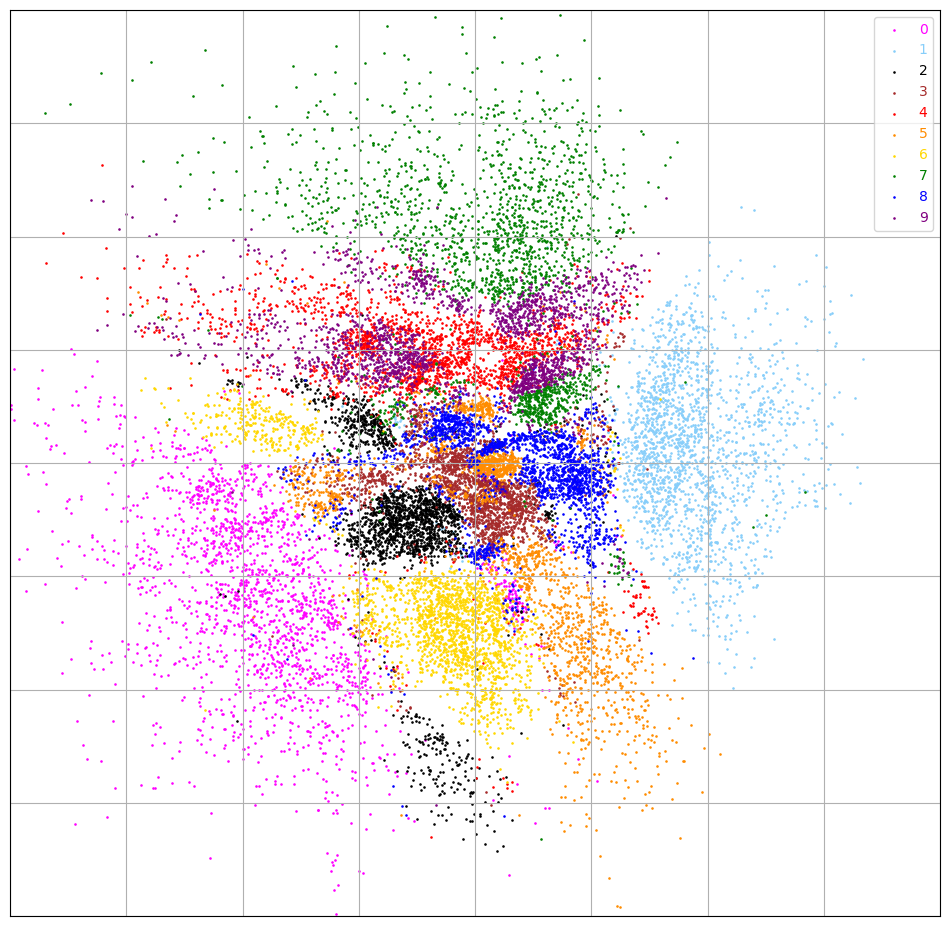

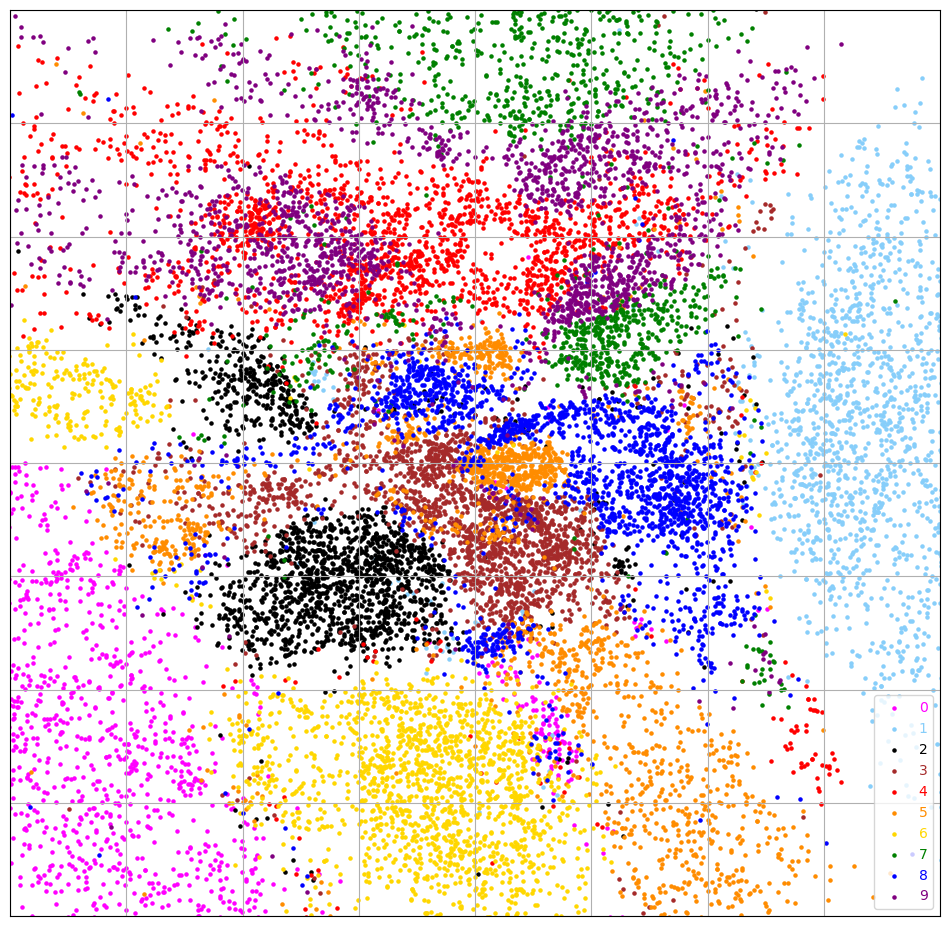

In [98]:
mu, logvar = model.encode(data)
z = mu.cpu().detach()#model.reparameterize(mu, logvar).cpu().detach()

print("modelled")

colors = ['magenta', 'lightskyblue', 'black', 'brown', 'red', 'darkorange', 'gold', 'green', 'blue', 'purple']
xpositions = [[] for i in range(10)]
ypositions = [[] for i in range(10)]

for pos,l in zip(z,label):
    xpositions[l].append(pos[0])
    ypositions[l].append(pos[1])

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 100
for i in range(10):
    plt.scatter(ypositions[i],xpositions[i],s=3,color=colors[i],marker='.',label=i)



plt.xlim(-4,4)
plt.ylim(4,-4)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.grid(True)
plt.legend(labelcolor=colors)
plt.show()

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 100
for i in range(10):
    plt.scatter(ypositions[i],xpositions[i],s=5,color=colors[i],marker='o',label=i)

plt.xlim(-2,2)
plt.ylim(2,-2)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.grid(True)
plt.legend(labelcolor=colors)
plt.show()

**To visualize the decoding part, span a two-dimensional grid over the entire latent representation and decode an image for each grid point; then, show all generated images in a plot matrix.**

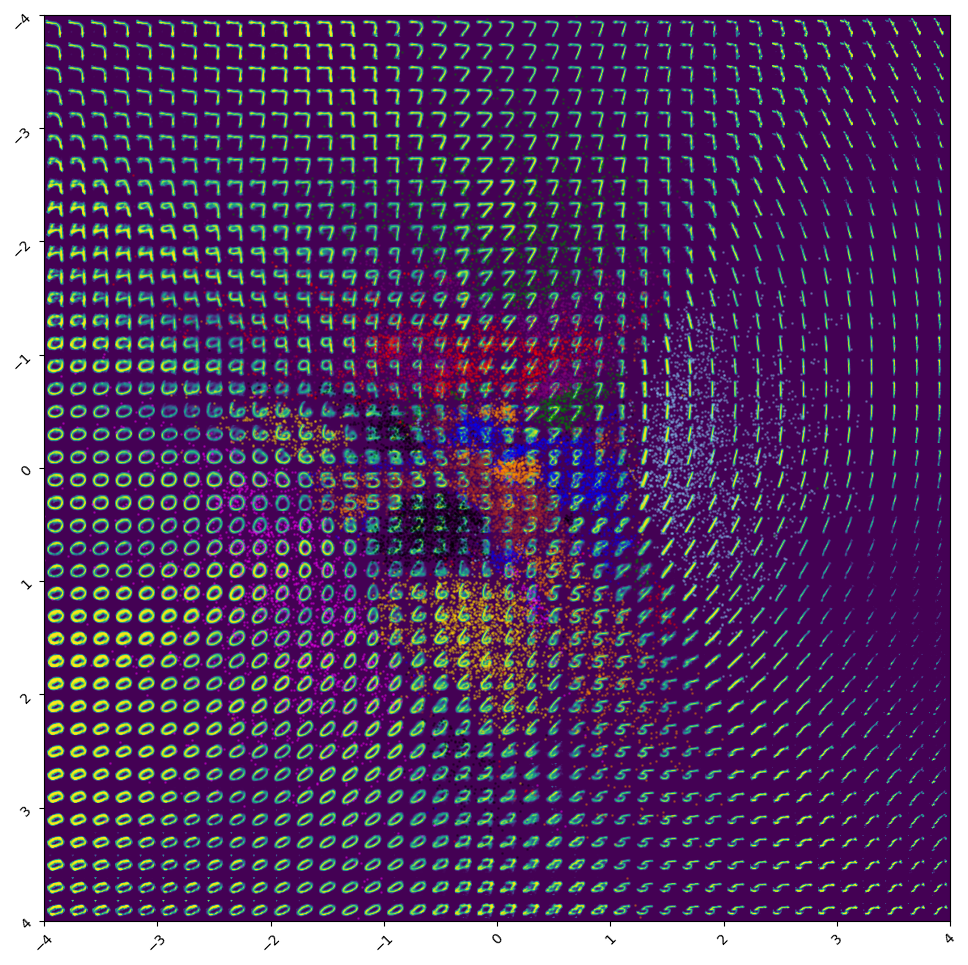

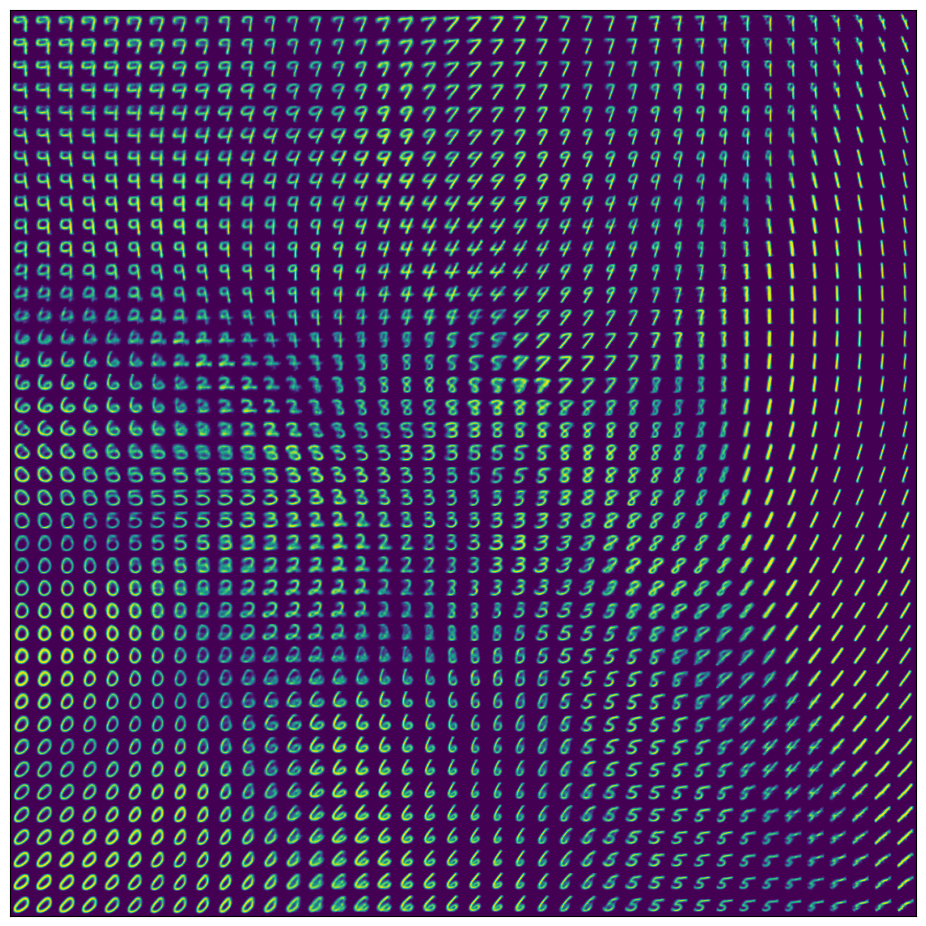

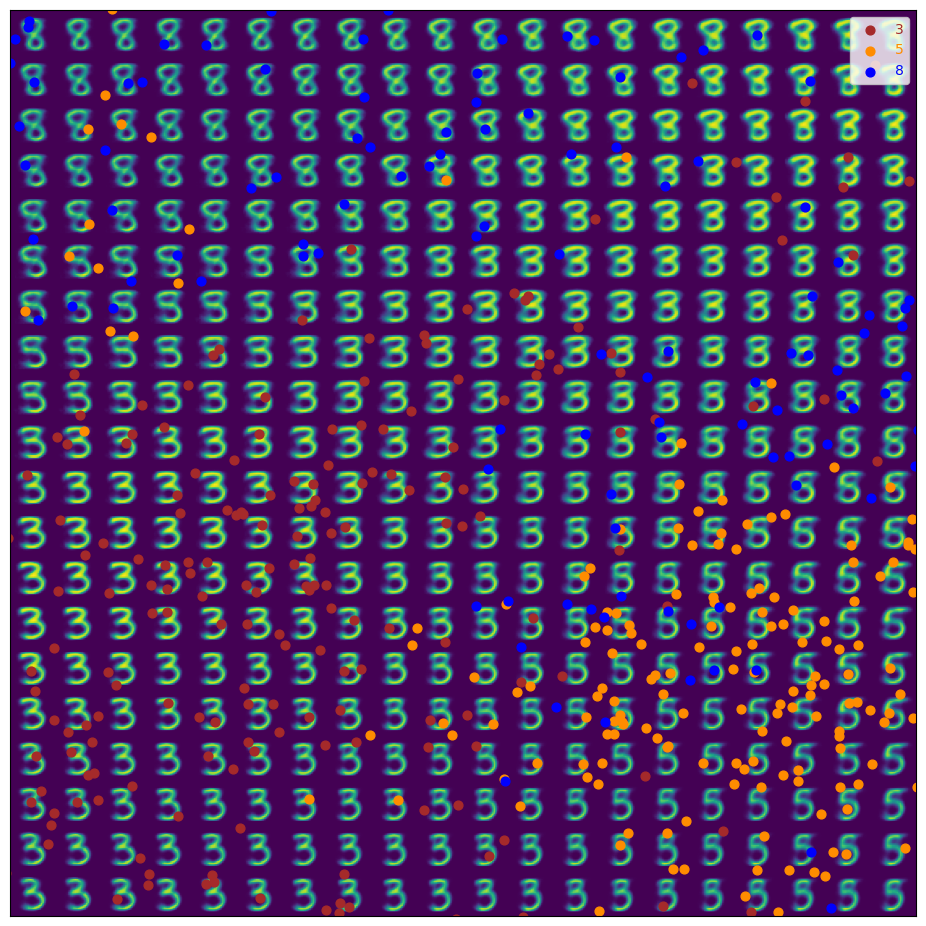

In [74]:
def showimg(img):
    plt.imshow(img.reshape(28,28))
    plt.show()

def decodeimg(x, y):
    return model.decode(torch.FloatTensor([[x, y]]).to('cuda:0')).cpu().detach().reshape(28,28)


#mu, logvar = model.encode(data[num].view(-1, 784))
#z = model.reparameterize(mu, logvar)
#print(z)

n_size = 40
extent = 4

grid_points_x, grid_points_y = np.mgrid[-extent:extent:n_size * 1j, -extent:extent:n_size * 1j]
outimg = np.zeros((28 * n_size, 28 * n_size))

for x in range(n_size):
    for y in range(n_size):
        outimg[x * 28 : x * 28 + 28, y * 28 : y * 28 + 28] = decodeimg(grid_points_x[x, y], grid_points_y[x, y])

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots()
#plt.imshow(outimg)
ax.imshow(outimg, extent = (-extent, extent, extent, -extent))#grid_points_x[:,0]
ticklabels = [f"{float(grid_points_x[i,0]):.2f}" for i in range(n_size)]
for i in range(10):
    ax.scatter(np.asarray(ypositions[i]), np.asarray(xpositions[i]),s=1,color=colors[i],marker='o',label=i,alpha=0.3)
#ax.set_xticks(np.linspace(14, 28 * n_size - 14, n_size))
#ax.set_yticks(np.linspace(14, 28 * n_size - 14, n_size))
#ax.set_xticklabels(ticklabels)
#ax.set_yticklabels(ticklabels)
plt.xlim(-extent,extent)
plt.ylim(extent,-extent)
ax.tick_params(rotation=45)
#ax.pcolor(grid_points_x[:,0], grid_points_y[0,:], outimg)
plt.show()



extent = 2

grid_points_x, grid_points_y = np.mgrid[-extent:extent:n_size * 1j, -extent:extent:n_size * 1j]
outimg = np.zeros((28 * n_size, 28 * n_size))

for x in range(n_size):
    for y in range(n_size):
        outimg[x * 28 : x * 28 + 28, y * 28 : y * 28 + 28] = decodeimg(grid_points_x[x, y], grid_points_y[x, y])

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots()
#plt.imshow(outimg)
ax.imshow(outimg)#grid_points_x[:,0]
ticklabels = [f"{float(grid_points_x[i,0]):.2f}" for i in range(n_size)]
ax.set_xticks(np.linspace(14, 28 * n_size - 14, n_size))
ax.set_yticks(np.linspace(14, 28 * n_size - 14, n_size))
ax.set_xticklabels(ticklabels)
ax.set_yticklabels(ticklabels)
ax.tick_params(rotation=45)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
#ax.pcolor(grid_points_x[:,0], grid_points_y[0,:], outimg)
plt.show()



extent = 0.25
n_size = 20

grid_points_x, grid_points_y = np.mgrid[-extent:0.1:n_size * 1j, -extent:0.1:n_size * 1j]
outimg = np.zeros((28 * n_size, 28 * n_size))

for x in range(n_size):
    for y in range(n_size):
        outimg[x * 28 : x * 28 + 28, y * 28 : y * 28 + 28] = decodeimg(grid_points_x[x, y], grid_points_y[x, y])

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots()
#plt.imshow(outimg)
ax.imshow(outimg, extent = (-extent, 0.1, 0.1, -extent))#grid_points_x[:,0]
ticklabels = [f"{float(grid_points_x[i,0]):.2f}" for i in range(n_size)]
for i in [3,5,8]:
    ax.scatter(np.asarray(ypositions[i]), np.asarray(xpositions[i]),s=40,color=colors[i],marker='o',label=i,alpha=1)
#ax.set_xticks(np.linspace(14, 28 * n_size - 14, n_size))
#ax.set_yticks(np.linspace(14, 28 * n_size - 14, n_size))
#ax.set_xticklabels(ticklabels)
#ax.set_yticklabels(ticklabels)
plt.xlim(-extent,0.1)
plt.ylim(0.1,-extent)
ax.tick_params(rotation=45)
plt.legend(labelcolor=[colors[3], colors[5], colors[8]])
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
#ax.pcolor(grid_points_x[:,0], grid_points_y[0,:], outimg)
plt.show()

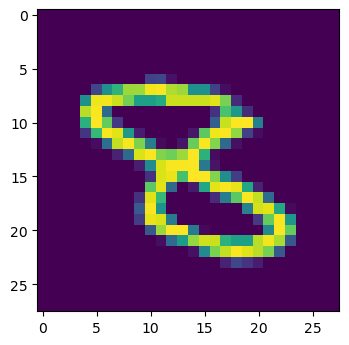

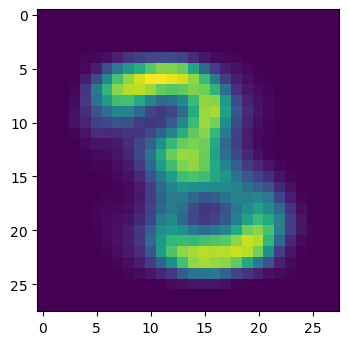

In [19]:
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 50
num = np.random.randint(0, data.shape[0])
showimg(data[num].to('cpu:0'))
recon_batch, mu, logvar = model.forward(data[num])
showimg(recon_batch.cpu().detach())

**Your task is to train a conditional variational autoencoder (CVAE) with one latent dimension (conditioned on the label or some form of it). Then, use your CVAE model to visualize which latent representation the model has learned, i.e., show where images are located by the encoder and which images can be generated given a position + label (CVAE).**


In [76]:
inputLayer = 28*28
hiddenLayer= [768, 128, 16]
outputLayer= 1
label_size = 10
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.dropout = lambda x : x #nn.Dropout(0.0)

        self.fc_encoder = [nn.Linear(inputLayer + label_size, hiddenLayer[0])]
        for in_size, out_size in zip(hiddenLayer[:-1], hiddenLayer[1:]):
            self.fc_encoder.append(nn.Linear(in_size, out_size))

        self.fc_encoder = torch.nn.ModuleList(self.fc_encoder)

        self.out_mu = nn.Linear(hiddenLayer[-1], outputLayer)
        self.out_logvar = nn.Linear(hiddenLayer[-1], outputLayer)

        self.fc_decoder = [nn.Linear(outputLayer + label_size, hiddenLayer[-1])] # outputLayer + label_size

        for in_size, out_size in zip(hiddenLayer[::-1][:-1], hiddenLayer[::-1][1:]):
            self.fc_decoder.append(nn.Linear(in_size, out_size))

        self.fc_decoder = torch.nn.ModuleList(self.fc_decoder)

        self.out_decoder = nn.Linear(hiddenLayer[0], inputLayer)

        self.transfer_function = nn.LeakyReLU()

        print(self.fc_encoder)
        print(self.fc_decoder)

    def encode(self, x, l):
        data_current = torch.cat([x, l], 1)
        for fc in self.fc_encoder:
            dat = self.dropout(data_current)
            fcl = fc(dat)
            data_current = self.transfer_function(fcl)

        return self.out_mu(self.dropout(data_current)), self.out_logvar(self.dropout(data_current))

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, l):
        data_current = torch.cat([z, l], 1)
        for fc in self.fc_decoder:
            data_current = self.transfer_function(fc(self.dropout(data_current)))
        #h3 = F.leaky_relu(self.fc3(z))
        return torch.sigmoid(self.out_decoder(self.dropout(data_current)))

    def forward(self, x, l):
        mu, logvar = self.encode(x.view(-1, inputLayer), l)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, l), mu, logvar

cvaemodel = CVAE()
#criterion = nn.NLLLoss()
optimizer_cvae = optim.Adam(cvaemodel.parameters(), lr=0.001)#, momentum=0.9)

def loss_function(recon_x, x, mu, logvar): # https://github.com/pytorch/examples/blob/master/vae/main.py
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

ModuleList(
  (0): Linear(in_features=794, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=16, bias=True)
)
ModuleList(
  (0): Linear(in_features=11, out_features=16, bias=True)
  (1): Linear(in_features=16, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=768, bias=True)
)


In [77]:
def labels_to_array(labels):
    arr = torch.zeros((len(labels), label_size))
    for i in range(len(labels)):
        arr[i, labels[i]] = 1
    return arr.to('cuda:0')

In [79]:
epochs = 100 # maximum
step_size = 500 # images per step for GPU acceleration


t0 = time()
#Tensoren und Model werden auf Grafikkarte geschoben zur schnelleren Berechnung
if torch.cuda.is_available():
    print("GPU support")
    cvaemodel.to('cuda:0')
else:
    print("no GPU support")
    step_size = 1
    epochs = 20

last_loss = 0

cvaemodel.train()

for i in range(epochs):
    t1=time()
    # shuffle trainigs set
    new_index=torch.randperm(data.shape[0])
    data=data[new_index]
    label=label[new_index]
    label_arr = labels_to_array(label)
    
    loss_ges=0
    for j in range(0, data.shape[0], step_size):
        optimizer_cvae.zero_grad
        # Train model to x = decode(reparameterize(encode(x)))
        curr_data = data[j:j+step_size]
        curr_labels = label_arr[j:j+step_size]
        result_batch, mu, logvar = cvaemodel(curr_data, curr_labels)
        loss = loss_function(result_batch, curr_data, mu, logvar)
        loss.backward()
        optimizer_cvae.step()
        loss_ges=loss_ges+loss.item()

    delta_t = time() - t1
    loss = loss_ges / data.shape[0]
    cdl = (loss - last_loss) * step_size / loss # corrected loss delta
    if True:#i % 50 == 0:
        print(f"epoch {i + 1} - loss: {loss:.2E} - delta loss: {loss - last_loss:.1E} - corrected delta loss: {cdl:.2f} - time: {delta_t:.1E} s - done in: {(time() - t0) * epochs / (i + 1):.1f} s    ", end="\r\u008D")
    last_loss = loss

cvaemodel.eval()

print()
print(f"training took {time() - t0} s")

GPU support
poch 1 - loss: 1.42E+02 - delta loss: 1.4E+02 - corrected delta loss: 500.00 - time: 5.1E-01 s - done in: 51.5 s    epoch 2 - loss: 1.42E+02 - delta loss: -1.3E-01 - corrected delta loss: -0.45 - time: 5.2E-01 s - done in: 51.6 s    epoch 3 - loss: 1.42E+02 - delta loss: -1.4E-02 - corrected delta loss: -0.05 - time: 5.1E-01 s - done in: 51.3 s    epoch 4 - loss: 1.42E+02 - delta loss: -1.5E-01 - corrected delta loss: -0.52 - time: 5.1E-01 s - done in: 51.4 s    epoch 5 - loss: 1.42E+02 - delta loss: -4.5E-02 - corrected delta loss: -0.16 - time: 5.1E-01 s - done in: 51.3 s    epoch 6 - loss: 1.42E+02 - delta loss: 2.4E-01 - corrected delta loss: 0.86 - time: 5.0E-01 s - done in: 51.1 s    epoch 7 - loss: 1.43E+02 - delta loss: 4.4E-01 - corrected delta loss: 1.53 - time: 5.1E-01 s - done in: 51.1 s    epoch 8 - loss: 1.44E+02 - delta loss: 1.4E+00 - corrected delta loss: 4.98 - time: 5.1E-01 s - done in: 51.1 s    epoch 9 - loss: 1.43E+02 - delta loss: -1.3E+00 - correcte

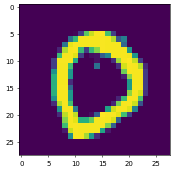

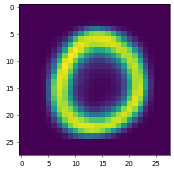

In [80]:
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 50
num = np.random.randint(0, data.shape[0])
showimg(data[num].to('cpu:0'))
recon_batch, mu, logvar = cvaemodel.forward(data[num], labels_to_array([label[num]]))
showimg(recon_batch.cpu().detach())

modelled


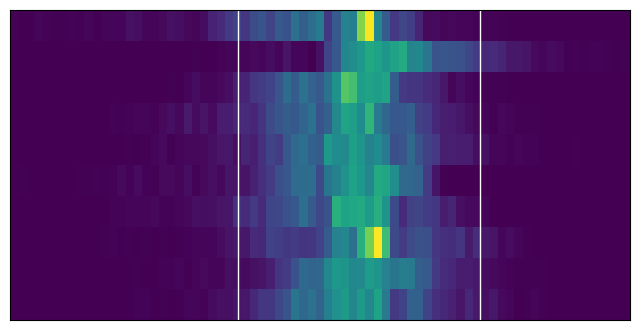

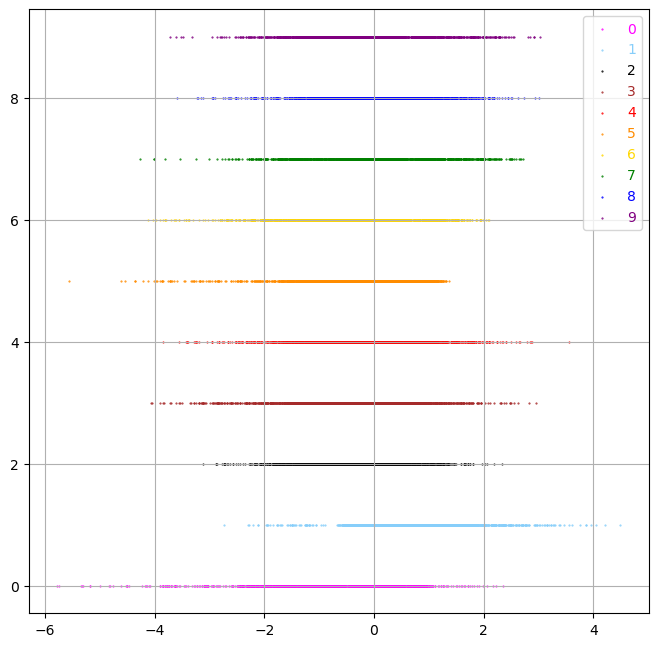

In [97]:
# Scatterbild

mu, logvar = cvaemodel.encode(data, labels_to_array(label))
z = model.reparameterize(mu, logvar).cpu().detach()

print("modelled")

colors = ['magenta', 'lightskyblue', 'black', 'brown', 'red', 'darkorange', 'gold', 'green', 'blue', 'purple']
xpositions = [[] for i in range(10)]
ypositions = [[] for i in range(10)]

for pos,l in zip(z.cpu(),label.cpu()):
    xpositions[l].append(pos[0])
    ypositions[l].append(l)

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 100
#plt.hist(xpositions)
#plt.show()

hist = np.asarray([np.histogram(xpos, bins=75, range = (np.min(xpositions), np.max(xpositions)))[0] for xpos in xpositions])
axis = np.asarray([np.histogram(xpos, bins=75, range = (np.min(xpositions), np.max(xpositions)))[1] for xpos in xpositions])
axis = (axis[:, :-1] + axis[:, 1:]) / 2
#print(hist)
#print(np.asarray([np.ones(len(hist[0])) * l for l in range(10)]))
#ax = plt.axes(projection ='3d')
#ax.plot_surface(axis.transpose(), hist.transpose(), np.asarray([np.ones(len(hist[0])) * l for l in range(10)]).transpose())

#ticklabels2 = [f"{i:d}" for i in range(10)]
#ax.set_yticks(np.linspace(0, 9, 10))
#ax.set_yticklabels(ticklabels2)
#ax.set_yticklabels(ticklabels2)
xmin = np.min(xpositions)
xmax = np.max(xpositions)

plt.imshow(hist, extent=(0,1,0.5,0))# extent = (np.min(xpositions), np.max(xpositions), 9.5, -0.5))
x = (-2 - xmin) / (xmax - xmin)
plt.plot([x,x], [0, 0.5], color="white", linestyle="-", linewidth=1)
x = (+2 - xmin) / (xmax - xmin)
plt.plot([x,x], [0, 0.5], color="white", linestyle="-", linewidth=1)

#ticklabels = [f"{float(grid_points_x[i]):.2f}" for i in range(n_size)]
ticklabels2 = [f"{i:d}" for i in range(10)]
#ax.set_xticks(np.linspace(14, 28 * n_size - 14, n_size))
ax.set_yticks(np.linspace(0,9, 10))
#ax.set_xticklabels(ticklabels)or(grid_points_x[:,0], grid_points_y[0,:], outimg)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
ax.set_yticklabels(ticklabels2)

plt.show()
#print(axis)

for i in range(10):
    plt.scatter(xpositions[i],ypositions[i],s=1,color=colors[i],marker='.',label=i)



#plt.xlim(-4,4)
#plt.ylim(4,-4)
plt.grid(True)
plt.legend(labelcolor=colors)
plt.show()


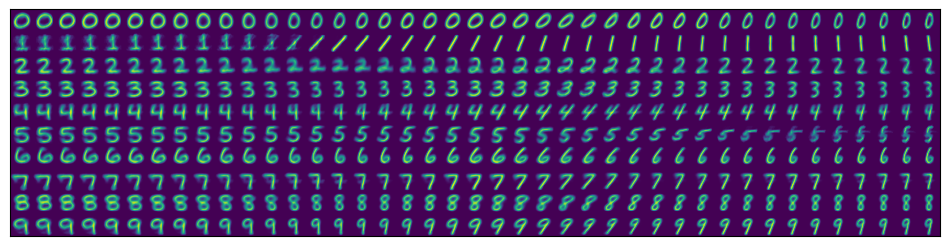

In [86]:
def label_to_array(labels):
    arr = torch.zeros((1, label_size))
    arr[0, labels] = 1
    return arr.to('cuda:0')

def cvaedecodeimg(x, y):
    return cvaemodel.decode(torch.FloatTensor([[x]]).to('cuda:0'), label_to_array(y)).cpu().detach().reshape(28,28)


n_size = 41
extent = 2

grid_points_x = np.linspace(-extent, extent, n_size)
outimg = np.zeros((28 * 10, 28 * n_size))

for x in range(n_size):
    for y in range(10):
        outimg[y * 28 : y * 28 + 28, x * 28 : x * 28 + 28] = cvaedecodeimg(grid_points_x[x], y)

#outimg = outimg.transpose()

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots()
#plt.imshow(outimg)
ax.tick_params(rotation=45)
ax.imshow(outimg)#grid_points_x[:,0]
ticklabels = [f"{float(grid_points_x[i]):.2f}" for i in range(n_size)]
ticklabels2 = [f"{i:d}" for i in range(10)]
ax.set_xticks(np.linspace(14, 28 * n_size - 14, n_size))
ax.set_yticks(np.linspace(14, 28 * 10 - 14, 10))
ax.set_xticklabels(ticklabels)
ax.set_yticklabels(ticklabels2)
#ax.pcolor(grid_points_x[:,0], grid_points_y[0,:], outimg)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.show()


Your submission must consist of a single jupyter notebook including the implementation of your models, the training process, visualizations, and explanatory text. Do not clear the figures/outputs before submitting.

You should first reproduce the VAE plots as described in the example using your own model and then adapt the visualization for the CVAE case; with CVAE, you have only one latent dimension but also the label information.

Using your visualizations, briefly explain the difference between the latent representations of VAE and CVAE

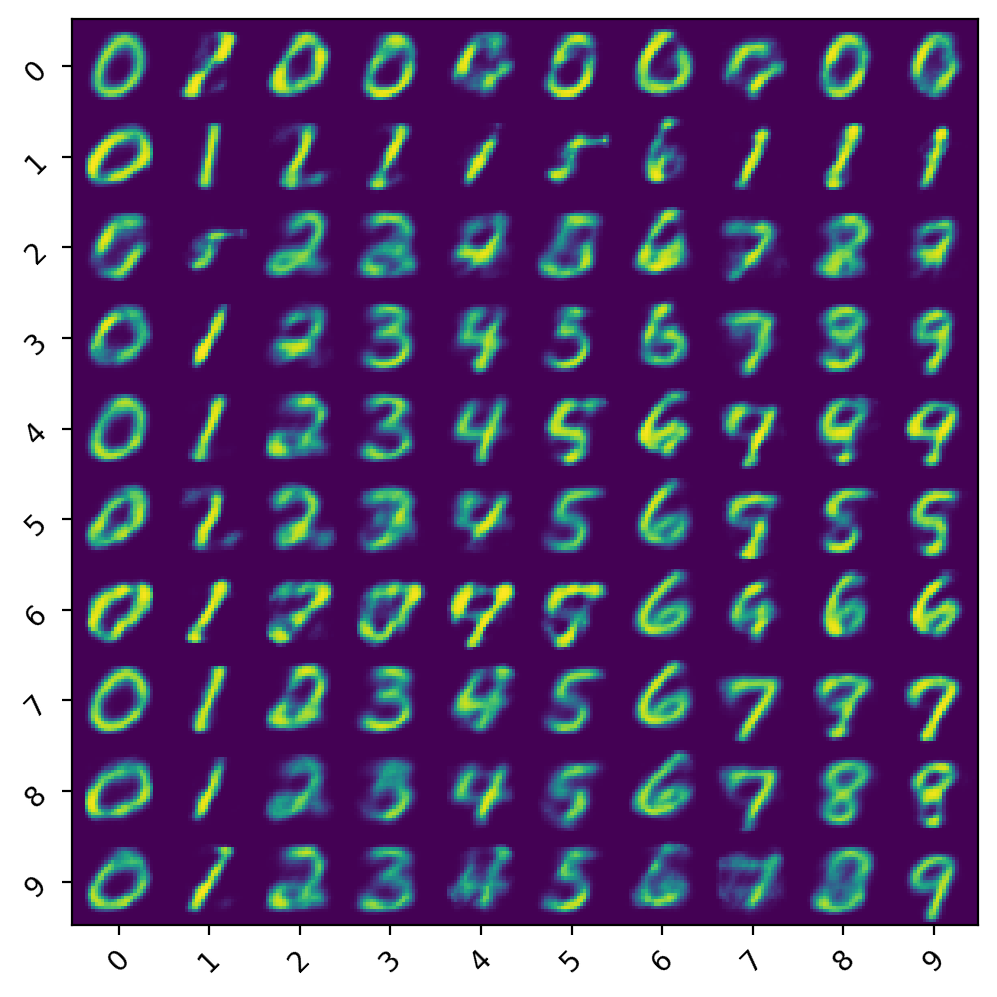

In [114]:
def cvaedecodeimg2(x, y):
    return cvaemodel.decode(torch.FloatTensor([[np.average((xpositions[x], xpositions[y]))]]).to('cuda:0'), label_to_array(x) + label_to_array(y) * (1 if x > y else (0 if x == y else -1))).cpu().detach().reshape(28,28)


extent = 10

#grid_points_x = np.linspace(-extent, extent, n_size)
outimg = np.zeros((28 * 10, 28 * 10))

for x in range(10):
    for y in range(10):
        outimg[y * 28 : y * 28 + 28, x * 28 : x * 28 + 28] = cvaedecodeimg2(x, y)

#outimg = outimg.transpose()

plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots()
#plt.imshow(outimg)
ax.tick_params(rotation=45)
ax.imshow(outimg)#grid_points_x[:,0]
ticklabels = [f"{i:d}" for i in range(10)]
ticklabels2 = [f"{i:d}" for i in range(10)]
ax.set_xticks(np.linspace(14, 28 * 10 - 14, 10))
ax.set_yticks(np.linspace(14, 28 * 10 - 14, 10))
ax.set_xticklabels(ticklabels)
ax.set_yticklabels(ticklabels2)
#ax.pcolor(grid_points_x[:,0], grid_points_y[0,:], outimg)
plt.show()